In [1]:
# install libraries for Google Colab
!pip install --upgrade tables
!pip install eli5
!pip install scikit-plot
!pip install xgboost
!pip install hyperopt

     |████████████████████████████████| 4.3MB 3.3MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 3.4MB/s 


In [2]:
# import libraries

import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler

# import models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Optimization
from functools import partial
from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


random_state=2020

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions

#### Load the data

In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
cd '/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution'

/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution


In [48]:
# load the wrangled and transformed data 
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df')

In [49]:
df.head()

datetime  apparentTemperature  cloudCover  dewPoint  humidity  \
0 2015-01-01 00:00:00                32.93         1.0     29.56      0.87   
1 2015-01-01 01:00:00                33.90         1.0     31.11      0.89   
2 2015-01-01 02:00:00                27.73         1.0     31.59      0.91   
3 2015-01-01 03:00:00                27.73         1.0     32.76      0.96   
4 2015-01-01 04:00:00                26.41         1.0     32.89      0.97   

      icon  precipIntensity  precipProbability  pressure   summary  \
0  unknown              0.0                0.0    1027.7   unknown   
1  unknown              0.0                0.0    1027.7   unknown   
2   cloudy              0.0                0.0    1027.7  Overcast   
3      fog              0.0                0.0    1027.7     Foggy   
4      fog              0.0                0.0    1027.7     Foggy   

   temperature  uvIndex  visibility  windBearing  windSpeed  PM25_nie  \
0        32.93      0.0       2.733        260.0       6.93   51.5034   
1        33.90      0.0       2.733        260.0       6.93   71.8204   
2        33.81      0.0       2.733        260.0       6.93   42.6996   
3        33.81      0.0       1.244        251.0       6.93   38.2824   
4        33.73      0.0       1.152        251.0       8.96   35.4194   

    PM25_wok  hour  day  dayofyear  weekday  month  year  IsWeekend  \
0  51.320000     0    1          1        3      1  2015          0   
1  68.982316     1    1          1        3      1  2015          0   
2  48.707108     2    1          1        3      1  2015          0   
3  37.986883     3    1          1        3      1  2015          0   
4  33.675489     4    1          1        3      1  2015          0   

   PM25_nie_mean  PM25_wok_mean  humidity_log  windSpeed_log  PM25_nie_log  \
0      41.406660      37.978489      0.625938       2.070653      3.960878   
1      58.400547      60.969357      0.636577       2.070653      4.287996   
2      50.865866      42.960510      0.647103       2.070653      3.777339   
3      43.679332      37.038594      0.672944       2.070653      3.670777   
4      36.976514      32.364739      0.678034       2.298577      3.595102   

   PM25_wok_log  apparentTemperature_lag1h  cloudCover_lag1h  dewPoint_lag1h  \
0      3.957379                  32.930000               1.0       29.559999   
1      4.248243                  32.930000               1.0       29.559999   
2      3.906148                  33.900002               1.0       31.110001   
3      3.663225                  27.730000               1.0       31.590000   
4      3.546033                  27.730000               1.0       32.759998   

   humidity_lag1h  precipIntensity_lag1h  precipProbability_lag1h  \
0            0.87                    0.0                      0.0   
1            0.87                    0.0                      0.0   
2            0.89                    0.0                      0.0   
3            0.91                    0.0                      0.0   
4            0.96                    0.0                      0.0   

   pressure_lag1h  temperature_lag1h  uvIndex_lag1h  visibility_lag1h  \
0     1027.699951          32.930000            0.0             2.733   
1     1027.699951          32.930000            0.0             2.733   
2     1027.699951          33.900002            0.0             2.733   
3     1027.699951          33.810001            0.0             2.733   
4     1027.699951          33.810001            0.0             1.244   

   windBearing_lag1h  windSpeed_lag1h  apparentTemperature_lag24h  \
0              260.0             6.93                       32.93   
1              260.0             6.93                       32.93   
2              260.0             6.93                       32.93   
3              260.0             6.93                       32.93   
4              251.0             6.93                       32.93   

   cloudCover_lag24h  dewPoint_lag24h 

In [50]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43848 entries, 0 to 43847
Data columns (total 168 columns):
 #   Column                                Dtype         
---  ------                                -----         
 0   datetime                              datetime64[ns]
 1   apparentTemperature                   float64       
 2   cloudCover                            float64       
 3   dewPoint                              float64       
 4   humidity                              float64       
 5   icon                                  object        
 6   precipIntensity                       float64       
 7   precipProbability                     float64       
 8   pressure                              float64       
 9   summary                               object        
 10  temperature                           float64       
 11  uvIndex                               float64       
 12  visibility                            float64       
 13  windBearing    

#### Split the data for train and test

In [51]:
# split the df for train and test, leave last 6 month for the test
train_mask = df['datetime'] < '2019-07-01'
test_mask = df['datetime'] >= '2019-07-01'

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

In [52]:
# check if the train dataset is correctly split
df_train.datetime.min(), df_train.datetime.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-06-30 23:00:00'))

In [53]:
# check if the test dataset is correctly split
df_test.datetime.min(), df_test.datetime.max()

(Timestamp('2019-07-01 00:00:00'), Timestamp('2019-12-31 23:00:00'))

#### Select original features and run simple models for benchmarking purpose

In [11]:
orig_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability', 'pressure', 'temperature',
              'uvIndex', 'visibility', 'windBearing', 'windSpeed', 'icon_num', 'summary_num']

In [12]:
# function to run different models
def run_model(feats, model, cross_val):
    X = df_train[feats].values
    y = df_train['PM25_nie_log'].values
    
    model_name = type(model).__name__

    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cross_val, scoring='neg_mean_squared_error'))
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    print("{} RMSE: {:.4f}, r2: {:.1f}%".format(model_name, np.mean(rmse), 100*np.mean(r2)))

In [13]:
# function to plot a learning curve for different models and scoring
def plot_lear_curve(feats, model, cross_val, scoring, ax):

  X = df_train[feats].values
  y = df_train['PM25_nie_log'].values

  model_name = type(model).__name__

  skplt.estimators.plot_learning_curve(model, X, y, cv=cross_val, scoring='r2', title=f'{model_name} Learning Curve', ax=ax);

In [11]:
# define Cross Validation
tcsv = TimeSeriesSplit(n_splits=5)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# define simple models for fast testing
DT_model = DecisionTreeRegressor(max_depth=3, random_state=random_state)
RF_model = RandomForestRegressor(max_depth=3, random_state=random_state)
XGB_model = xgb.XGBRegressor(max_depth=3, objective='reg:squarederror', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(max_depth=3, objective='regression', random_state=random_state)

In [15]:
models = [DT_model, RF_model, XGB_model, LGBM_model]

for model in models:
    run_model(orig_feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.4983, r2: 23.5%
RandomForestRegressor RMSE: 0.4819, r2: 28.6%
XGBRegressor RMSE: 0.4593, r2: 30.8%
LGBMRegressor RMSE: 0.4569, r2: 31.9%


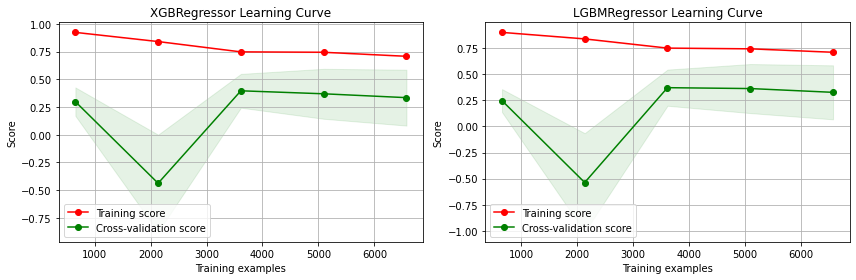

In [16]:
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[2:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(orig_feats, model, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [17]:
for model in models:
    run_model(orig_feats, model, kf)

DecisionTreeRegressor RMSE: 0.4769, r2: 39.0%
RandomForestRegressor RMSE: 0.4716, r2: 40.3%
XGBRegressor RMSE: 0.3972, r2: 57.6%
LGBMRegressor RMSE: 0.3973, r2: 57.6%


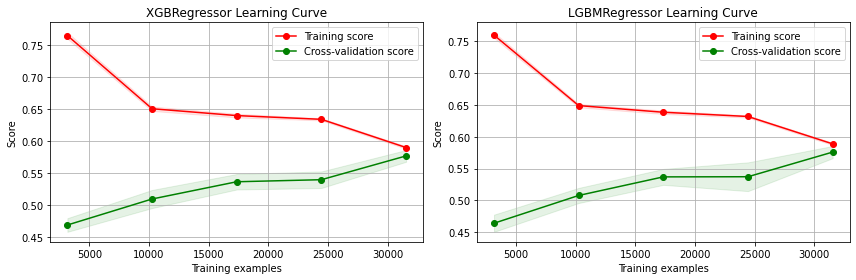

In [18]:
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[2:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(orig_feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

#### Extend original features with time based features

In [19]:
time_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability', 'pressure', 'temperature',
              'uvIndex', 'visibility', 'windBearing', 'windSpeed', 'icon_num', 'summary_num',
              'year', 'month', 'day', 'dayofyear', 'hour', 'weekday', 'IsWeekend',
              'Autumn', 'Spring', 'Summer', 'Winter']

In [20]:
for model in models:
    run_model(time_feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.5104, r2: 19.3%
RandomForestRegressor RMSE: 0.4925, r2: 25.1%
XGBRegressor RMSE: 0.4003, r2: 50.5%
LGBMRegressor RMSE: 0.3985, r2: 50.8%


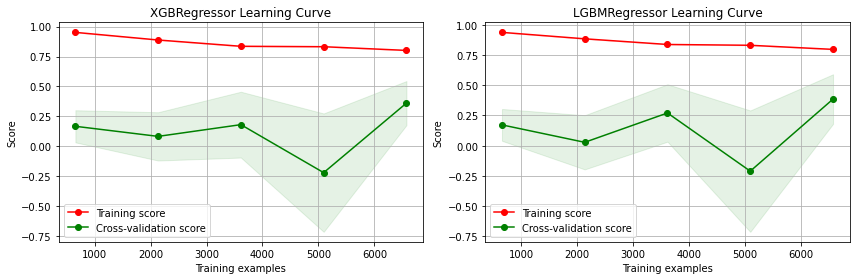

In [21]:
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[2:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(time_feats, model, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [22]:
for model in models:
    run_model(time_feats, model, kf)

DecisionTreeRegressor RMSE: 0.4706, r2: 40.5%
RandomForestRegressor RMSE: 0.4644, r2: 42.1%
XGBRegressor RMSE: 0.3505, r2: 67.0%
LGBMRegressor RMSE: 0.3499, r2: 67.1%


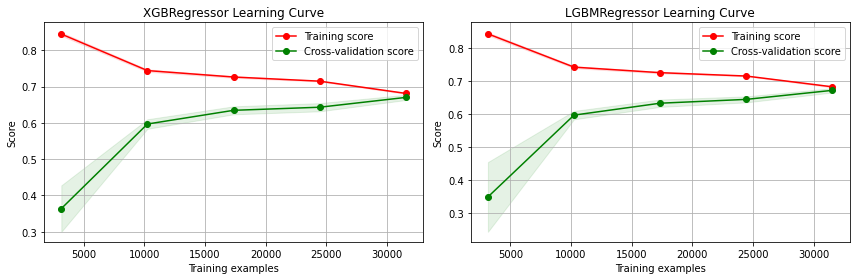

In [23]:
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[2:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(time_feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

#### Quick check of XGBoost prediction errors with KFold

In [24]:
X = df_train[time_feats].values
y = df_train['PM25_nie_log'].values

X_test = df_test[time_feats].values

XGB_model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=2020, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

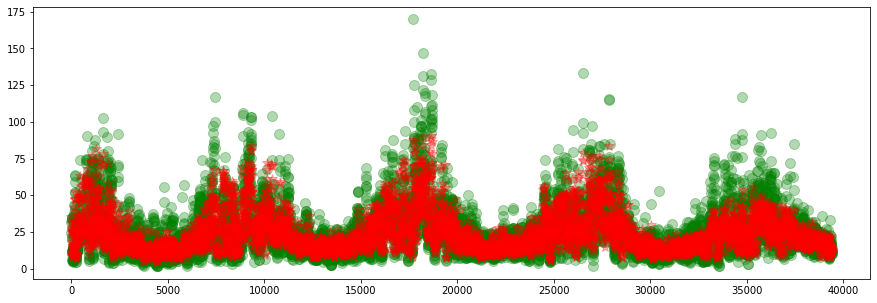

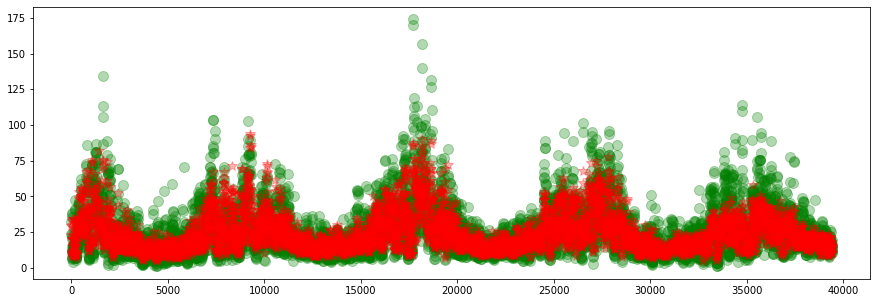

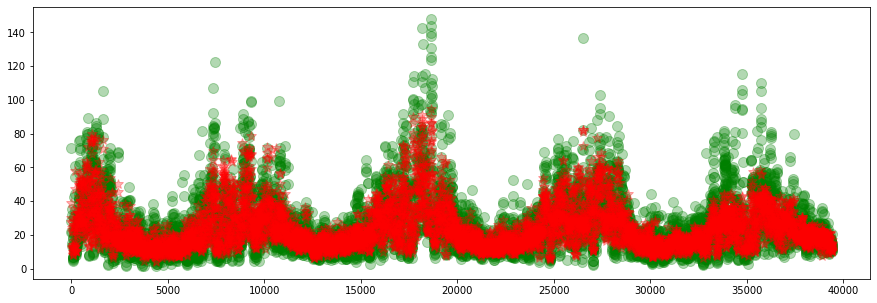

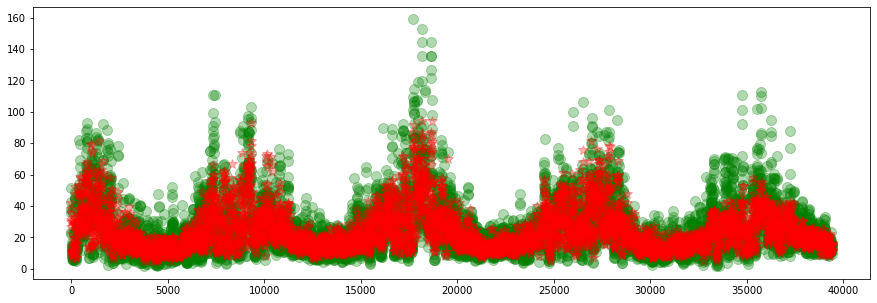

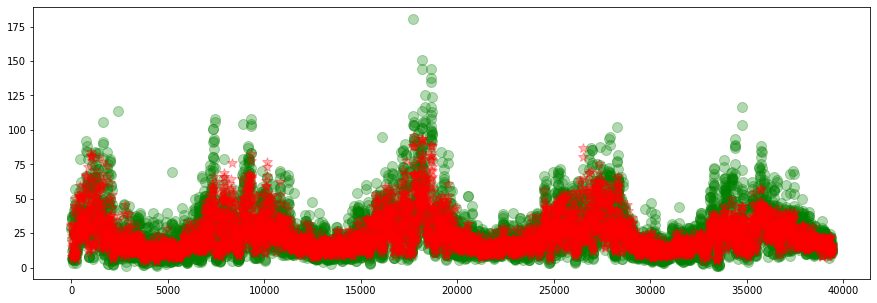

In [25]:
for train_idx, test_idx in kf.split(y):
    train = y[train_idx]
    test = y[test_idx]
    y_log_pred = XGB_model.predict(X[test_idx])
        
    y_true = np.expm1(train)
    y_test = np.expm1(test)
    y_pred = np.expm1(y_log_pred)

    plt.figure(figsize=(15, 5))
    #plt.plot(train_idx, y_true, 'bo', alpha=0.3, ms=10, lw='3', label='train')
    plt.plot(test_idx, y_test, 'go',alpha=0.3, ms=10, lw='3', label='test')
    plt.plot(test_idx, y_pred, 'r*', alpha=0.3, ms=10, lw='3', label='forecast')

#### Select new features and run simple models

In [26]:
# function to get all numerical features, except the one related to PM2.5 and Wokalna Street measures
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['PM25_nie',
                  'PM25_wok',
                  'PM25_nie_log',
                  'PM25_wok_log',
                  'PM25_nie_mean',
                  'PM25_wok_mean',
                  'mean_PM25_nie_per_day',
                  'mean_PM25_wok_per_day',
                  'mean_PM25_nie_log_per_day',
                  'mean_PM25_wok_log_per_day',
                  'median_PM25_nie_per_day',
                  'median_PM25_wok_per_day',
                  'median_PM25_nie_log_per_day',
                  'median_PM25_wok_log_per_day',
                  'mean_PM25_nie_per_month',
                  'mean_PM25_wok_per_month',
                  'mean_PM25_nie_log_per_month',
                  'mean_PM25_wok_log_per_month',
                  'median_PM25_nie_per_month',
                  'median_PM25_wok_per_month',
                  'median_PM25_nie_log_per_month',
                  'median_PM25_wok_log_per_month',
                  'PM25_nie_diff_for_day_median',
                  'PM25_nie_diff_for_day_mean',
                  'PM25_nie_diff_for_month_median',
                  'PM25_nie_diff_for_month_mean',
                  'PM25_wok_diff_for_day_median',
                  'PM25_wok_diff_for_day_mean',
                  'PM25_wok_diff_for_month_median',
                  'PM25_wok_diff_for_month_mean']

    return [x for x in feats if x not in black_list]

In [27]:
#get feats
feats = get_feats(df_train)

In [28]:
for model in models:
    run_model(feats, model, tcsv)

DecisionTreeRegressor RMSE: 0.5067, r2: 20.0%
RandomForestRegressor RMSE: 0.4677, r2: 32.1%
XGBRegressor RMSE: 0.3716, r2: 56.9%
LGBMRegressor RMSE: 0.3744, r2: 56.1%


In [29]:
for model in models:
    run_model(feats, model, kf)

DecisionTreeRegressor RMSE: 0.4376, r2: 48.6%
RandomForestRegressor RMSE: 0.4278, r2: 50.9%
XGBRegressor RMSE: 0.3054, r2: 75.0%
LGBMRegressor RMSE: 0.3054, r2: 75.0%


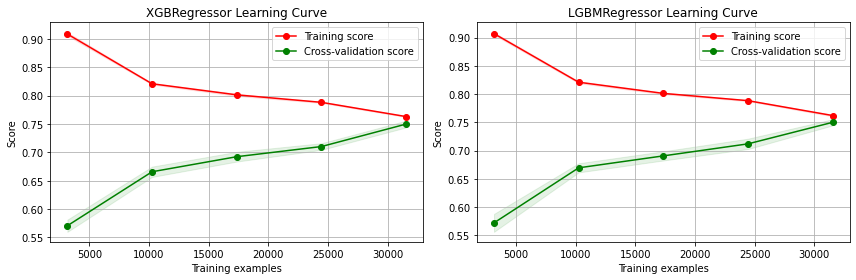

In [30]:
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models[2:]):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(feats, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

#### Check feature importance for XGB and LGBM

In [31]:
# fit XGB model

X = df_train[feats].values
y = df_train['PM25_nie_log'].values

XGB_model.fit(X, y)

perm = PermutationImportance(XGB_model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=25)

In [32]:
# fit LGBM model

X = df_train[feats].values
y = df_train['PM25_nie_log'].values

LGBM_model.fit(X, y)

perm = PermutationImportance(LGBM_model).fit(X, y)
eli5.show_weights(perm, feature_names=feats, top=25)

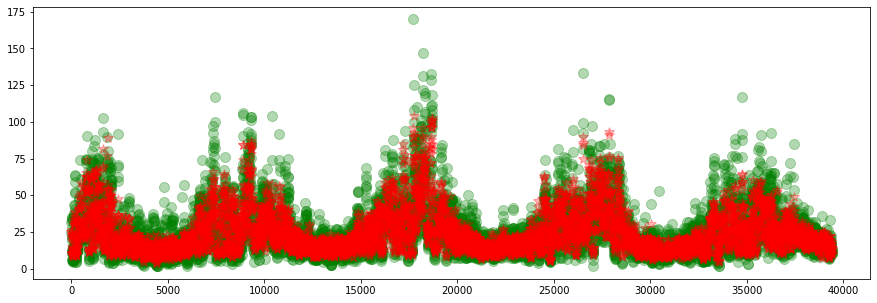

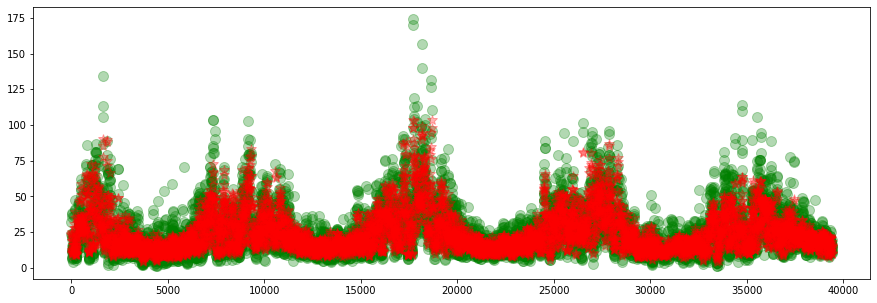

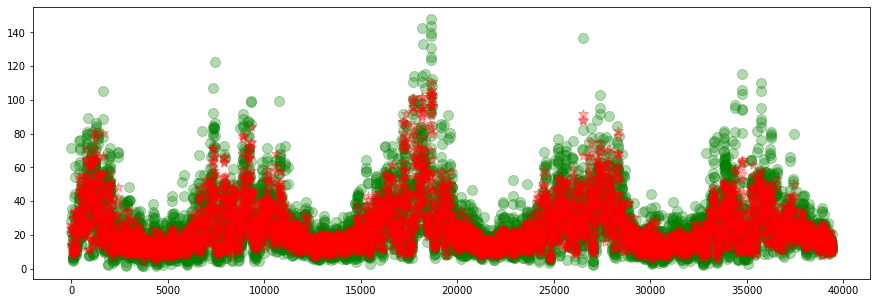

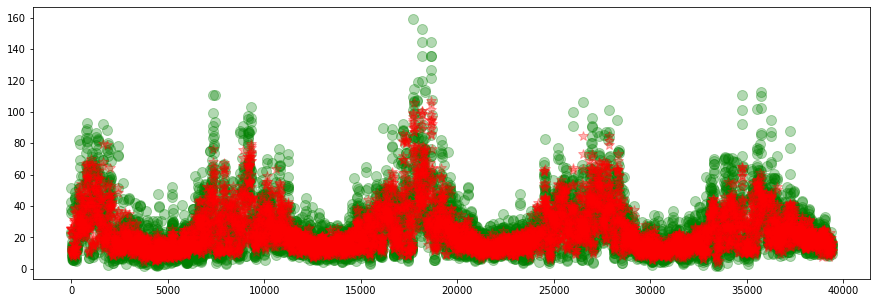

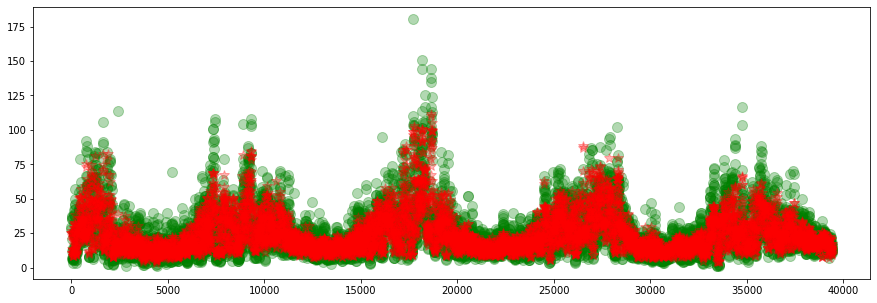

In [33]:
for train_idx, test_idx in kf.split(y):
    train = y[train_idx]
    test = y[test_idx]
    y_log_pred = XGB_model.predict(X[test_idx])
        
    y_true = np.expm1(train)
    y_test = np.expm1(test)
    y_pred = np.expm1(y_log_pred)

    plt.figure(figsize=(15, 5))
    #plt.plot(train_idx, y_true, 'bo', alpha=0.3, ms=10, lw='3', label='train')
    plt.plot(test_idx, y_test, 'go',alpha=0.3, ms=10, lw='3', label='test')
    plt.plot(test_idx, y_pred, 'r*', alpha=0.3, ms=10, lw='3', label='forecast')

#### Select top 25 features

In [12]:
features = [
            'mean_apparentTemperature_per_month',
            'windSpeed_rolling24h',
            'windSpeed_rolling12h',
            'dewPoint',
            'windSpeed_lag1h',
            'dewPoint_rolling168h',
            'visibility',
            'humidity',
            'year',
            'windBearing_lag1h',
            'temperature_rolling168h',
            'windBearing_rolling168h',
            'hour',
            'cloudCover_rolling24h',
            'median_apparentTemperature_per_day',
            'visibility_lag1h',
            'mean_visibility_per_day',
            'humidity_lag1h',
            'mean_uvIndex_per_day',
            'weekday',
            'windSpeed',
            'mean_apparentTemperature_per_day',
            'windBearing',
            'windBearing_lag24h',
            'windBearing_rolling12h'
            ]

In [35]:
XGB_model = xgb.XGBRegressor(max_depth=8, n_estimators=100, objective='reg:squarederror', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(max_depth=8, n_estimators=100, objective='regression', random_state=random_state)

In [36]:
models = [XGB_model, LGBM_model]

for model in models:
    run_model(features, model, kf)

XGBRegressor RMSE: 0.2038, r2: 88.8%
LGBMRegressor RMSE: 0.2531, r2: 82.8%


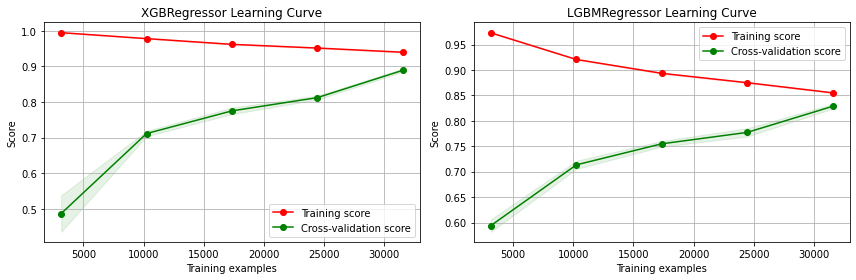

In [37]:
fig=plt.figure(figsize=(12,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,2,i+1)
    plot_lear_curve(features, model, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

#### Run HyperOpt for XGBoost

In [13]:
X = df_train[features].values
y = df_train['PM25_nie_log'].values

def objective(space):
    
    XGB_model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                           max_depth = int(space['max_depth']),
                           min_child_weight = space['min_child_weight'],
                           subsample = space['subsample'],
                           learning_rate = space['learning_rate'],
                           gamma = space['gamma'],
                           colsample_bytree = space['colsample_bytree'],
                           objective='reg:squarederror',
                           random_state=random_state
                           )
    
    for train_idx, test_idx in kf.split(X):

        eval_set  = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = XGB_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice ('max_depth', np.arange(2, 8, 1, dtype=int)),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 1000, 2, dtype=int)),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
    }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2837, r2: 78.5%
RMSE: 0.2218, r2: 86.9%
RMSE: 0.2243, r2: 86.6%
RMSE: 0.2315, r2: 85.7%
RMSE: 0.2191, r2: 87.2%
RMSE: 0.2189, r2: 87.2%
RMSE: 0.2187, r2: 87.2%
RMSE: 0.3405, r2: 69.1%
RMSE: 0.2242, r2: 86.6%
RMSE: 0.2824, r2: 78.7%
100%|██████████| 10/10 [04:15<00:00, 25.56s/it, best loss: 0.21869152861384744]
The best params:  {'colsample_bytree': 1.0, 'gamma': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'min_child': 10.0, 'n_estimators': 477, 'subsample': 0.7035836680969818}


In [14]:
XGB_model = xgb.XGBRegressor(**best, objective='reg:squarederror', random_state=random_state)
XGB_model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=1.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child=10.0, min_child_weight=1, missing=None,
             n_estimators=477, n_jobs=1, nthread=None,
             objective='reg:squarederror', random_state=2020, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=0.7035836680969818, verbosity=1)

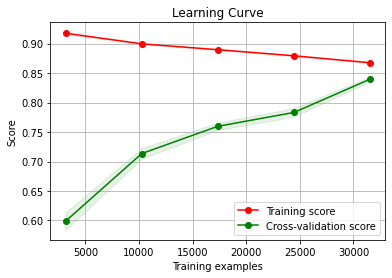

In [15]:
skplt.estimators.plot_learning_curve(XGB_model, X, y, cv=kf,scoring='r2');

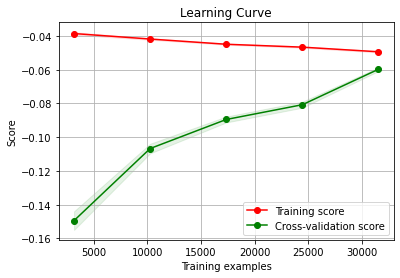

In [16]:
skplt.estimators.plot_learning_curve(XGB_model, X, y, cv=kf, scoring='neg_mean_squared_error');

In [17]:
perm = PermutationImportance(XGB_model).fit(X, y)
eli5.show_weights(perm, feature_names=features, top=25)

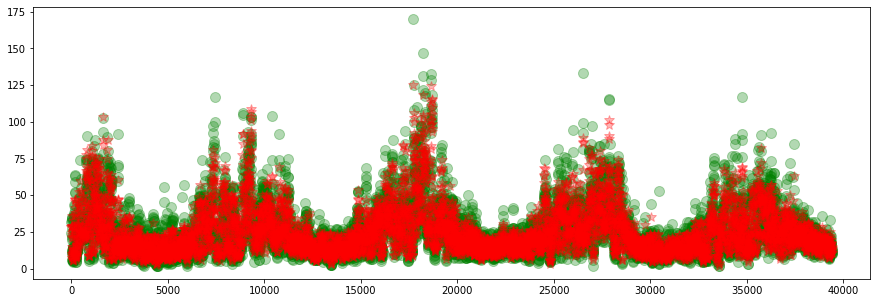

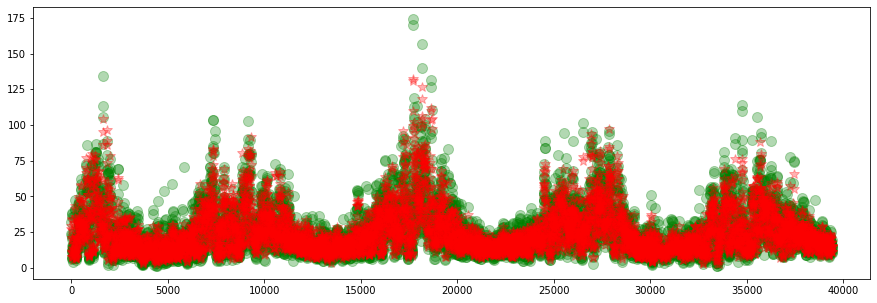

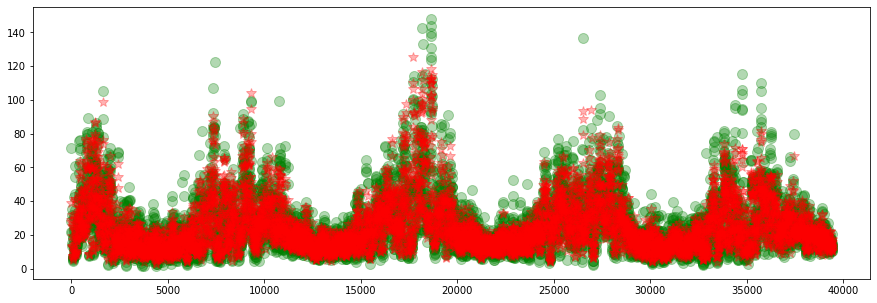

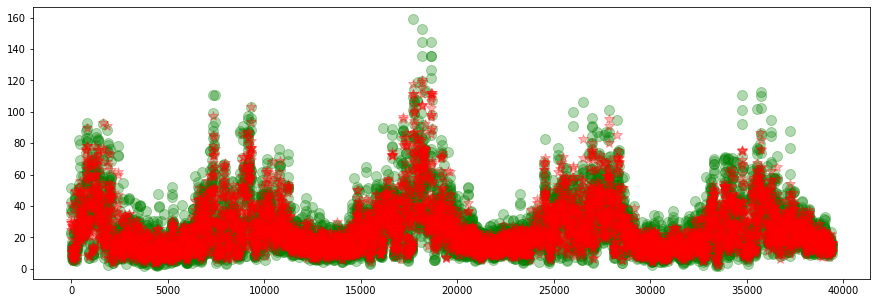

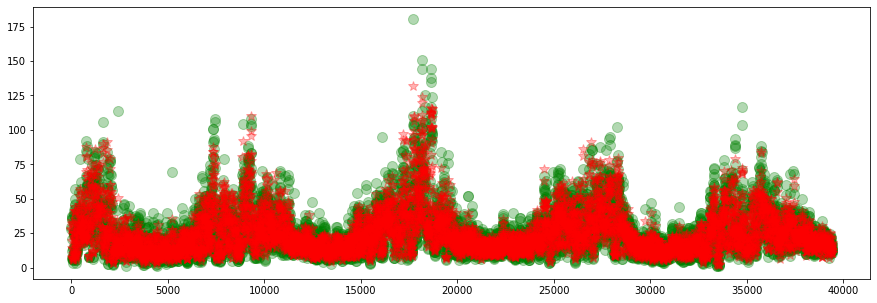

In [18]:
for train_idx, test_idx in kf.split(y):
    train = y[train_idx]
    test = y[test_idx]
    y_log_pred = XGB_model.predict(X[test_idx])
        
    y_true = np.expm1(train)
    y_test = np.expm1(test)
    y_pred = np.expm1(y_log_pred)

    plt.figure(figsize=(15, 5))
    plt.plot(test_idx, y_test, 'go',alpha=0.3, ms=10, lw='3', label='test')
    plt.plot(test_idx, y_pred, 'r*', alpha=0.3, ms=10, lw='3', label='forecast')

#### Run HyperOpt for LightGBM

In [19]:
def objective(space):
    
    LGBM_model = lgb.LGBMRegressor(
                max_depth = int(space['max_depth']),
                n_estimators = space['n_estimators'],
                min_child_weight = space['min_child_weight'],
                subsample = space['subsample'],
                learning_rate = space['learning_rate'],
                gamma = space['gamma'],
                colsample_bytree = space['colsample_bytree'],
                objective='regression',
                random_state=random_state
                )
    
    for train_idx, test_idx in kf.split(X):

        eval_set  = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
        LGBM_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
        y_pred = LGBM_model.predict(X[test_idx])

        rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
        r2 = r2_score(y[test_idx], y_pred)
        
        print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
        return{'loss': rmse, 'status': STATUS_OK }
    
    
space ={
        'max_depth': hp.choice ('max_depth', np.arange(2, 8, 1, dtype=int)),
        'n_estimators' : hp.choice('n_estimators', np.arange(10, 1000, 2, dtype=int)),
        'min_child_weight': hp.quniform ('min_child', 1, 10, 1),
        'subsample': hp.uniform ('subsample', 0.7, 1),
        'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=10,
            trials=trials)

print("The best params: ", best)

RMSE: 0.2107, r2: 88.2%
RMSE: 0.3372, r2: 69.7%
RMSE: 0.1837, r2: 91.0%
RMSE: 0.1914, r2: 90.2%
RMSE: 0.2516, r2: 83.1%
RMSE: 0.2692, r2: 80.7%
RMSE: 0.1860, r2: 90.8%
RMSE: 0.3901, r2: 59.4%
RMSE: 0.1743, r2: 91.9%
RMSE: 0.1828, r2: 91.1%
100%|██████████| 10/10 [00:41<00:00,  4.18s/it, best loss: 0.17427720125901172]
The best params:  {'colsample_bytree': 0.8500000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.2, 'max_depth': 3, 'min_child': 3.0, 'n_estimators': 470, 'subsample': 0.7128260301698495}


In [20]:
LGBM_model = lgb.LGBMRegressor(**best, objective='regression', random_state=random_state)
LGBM_model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.8500000000000001, gamma=0.8500000000000001,
              importance_type='split', learning_rate=0.2, max_depth=3,
              min_child=3.0, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=470, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.7128260301698495,
              subsample_for_bin=200000, subsample_freq=0)

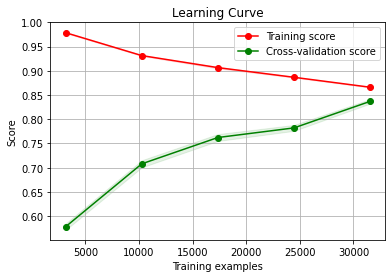

In [21]:
skplt.estimators.plot_learning_curve(LGBM_model, X, y, cv=kf, scoring='r2');

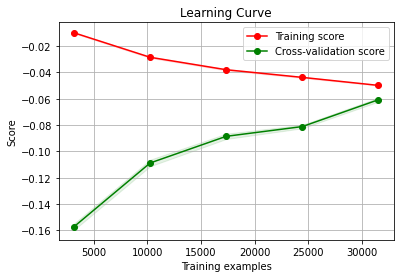

In [22]:
skplt.estimators.plot_learning_curve(LGBM_model, X, y, cv=kf, scoring='neg_mean_squared_error');

In [23]:
perm = PermutationImportance(LGBM_model).fit(X, y)
eli5.show_weights(perm, feature_names=features, top=25)

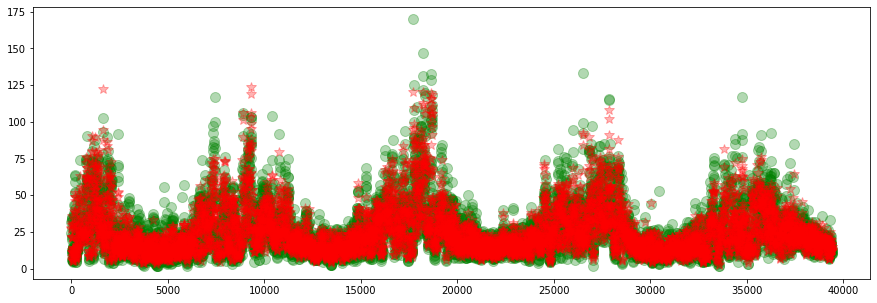

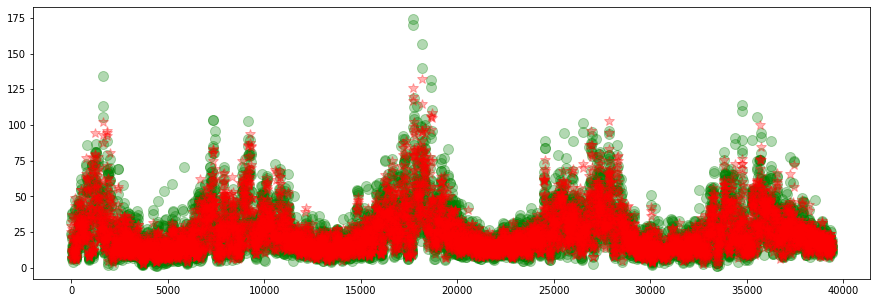

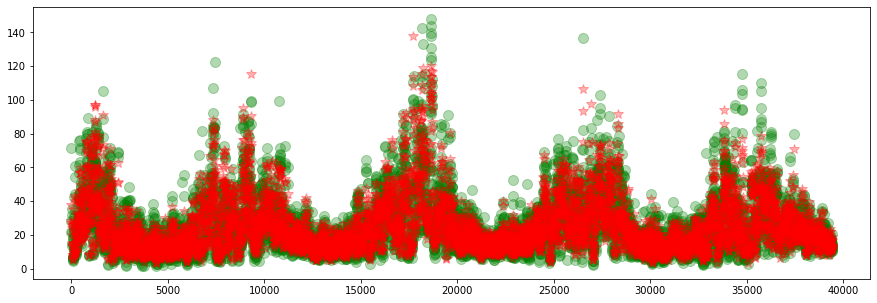

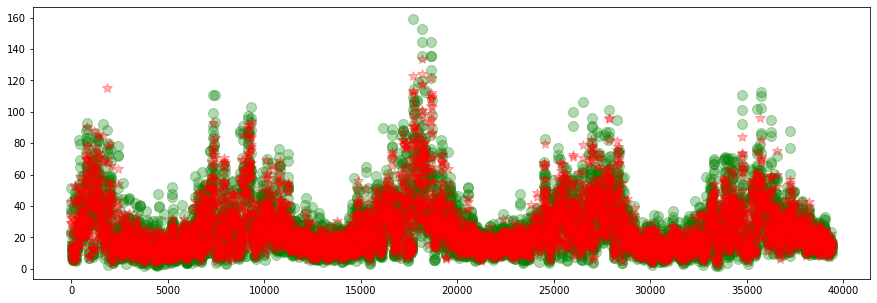

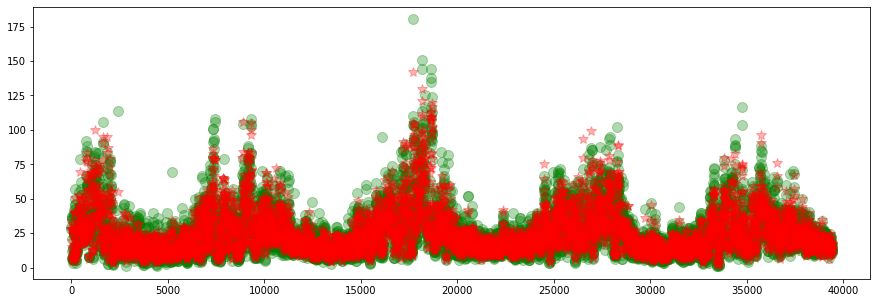

In [24]:
for train_idx, test_idx in kf.split(y):
    train = y[train_idx]
    test = y[test_idx]
    y_log_pred = LGBM_model.predict(X[test_idx])
        
    y_true = np.expm1(train)
    y_test = np.expm1(test)
    y_pred = np.expm1(y_log_pred)

    plt.figure(figsize=(15, 5))
    plt.plot(test_idx, y_test, 'go',alpha=0.3, ms=10, lw='3', label='test')
    plt.plot(test_idx, y_pred, 'r*', alpha=0.3, ms=10, lw='3', label='forecast')

#### Predict on test data

In [54]:
X = df_train[features].values
y = df_train['PM25_nie_log'].values
X_test = df_test[features].values


y_test_XGB = XGB_model.predict(X_test)
y_test_LGBM = LGBM_model.predict(X_test)

df_test['PM25_nie_pred_xgb'] = np.expm1(y_test_XGB)
df_test['PM25_nie_pred_lgbm'] = np.expm1(y_test_LGBM)

In [55]:
xgb_rmse = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb']))
xgb_r2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb'])

lgbm_rmse = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm']))
lgbm_r2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm'])

In [56]:
print("XGBoost: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse, 100*np.mean(xgb_r2)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse, 100*np.mean(lgbm_r2)))

XGBoost: RMSE: 7.0626, r2: 54.4%
LightGBM: RMSE: 8.2929, r2: 37.2%


In [57]:
months = df_test.month.unique().tolist()
months

[7, 8, 9, 10, 11, 12]

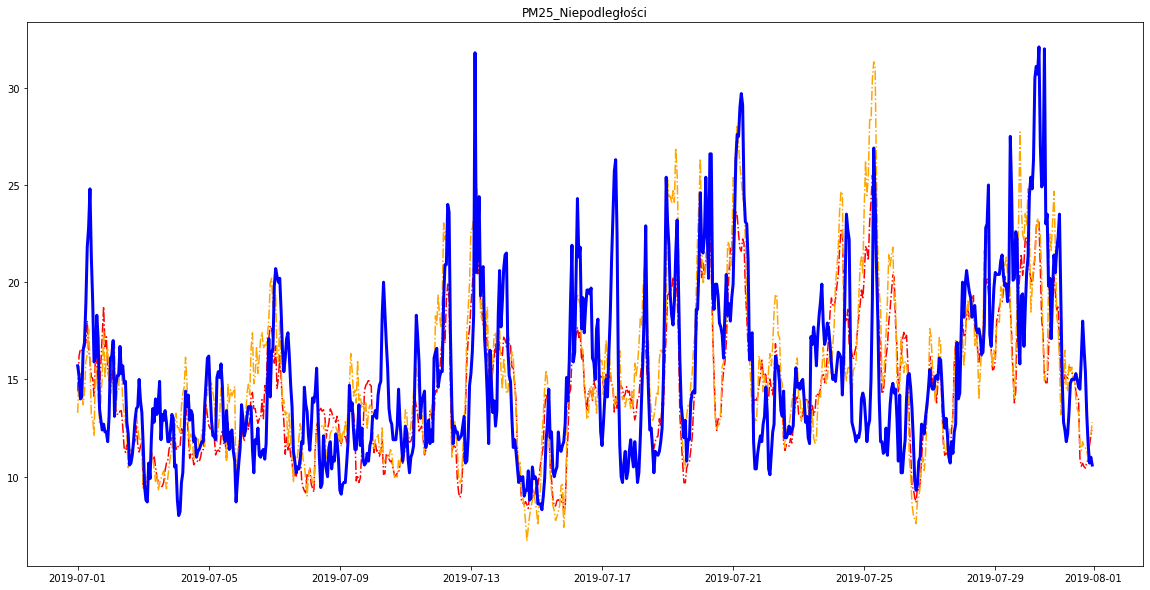

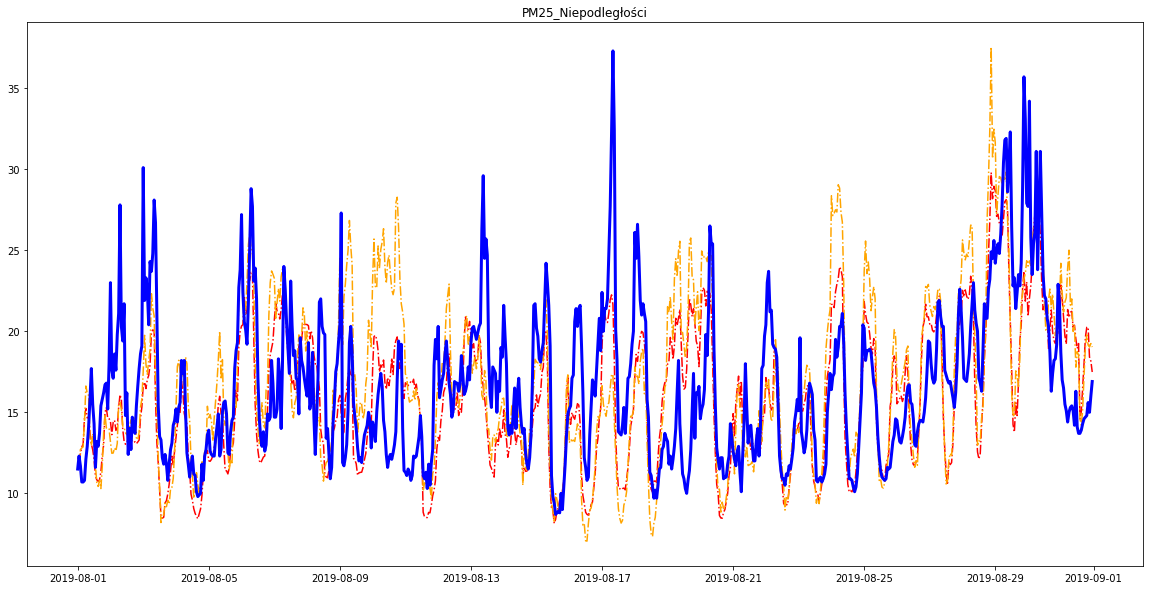

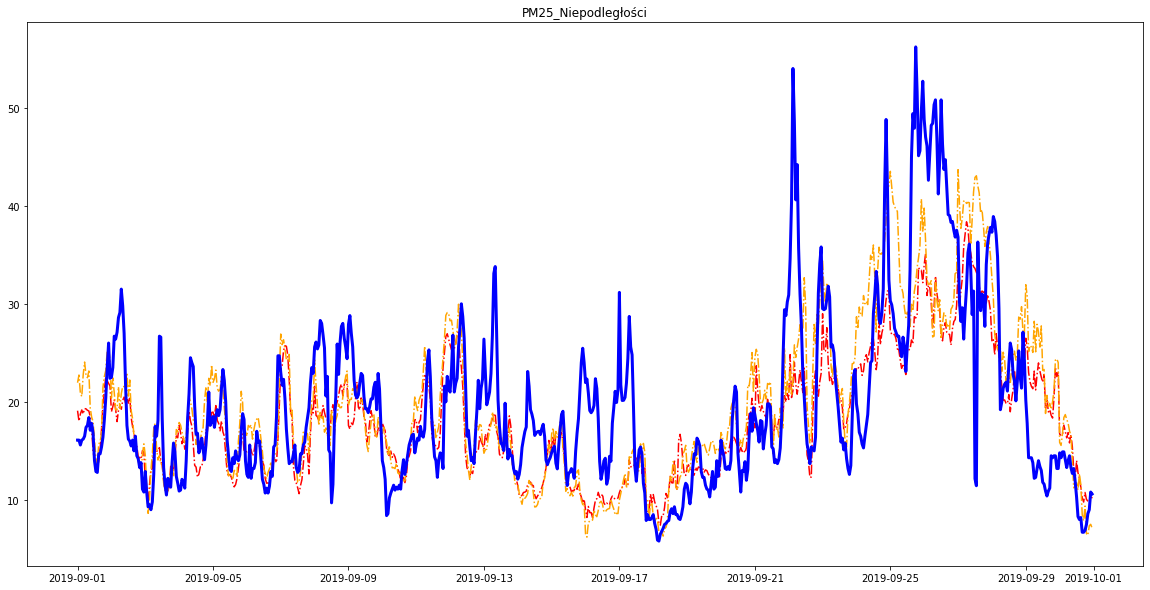

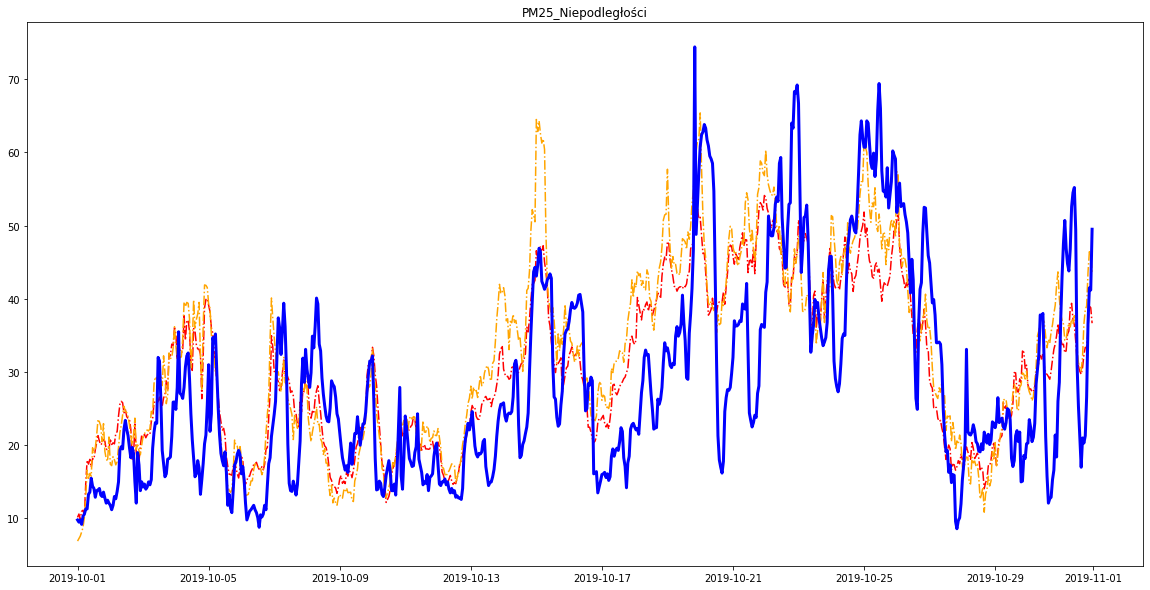

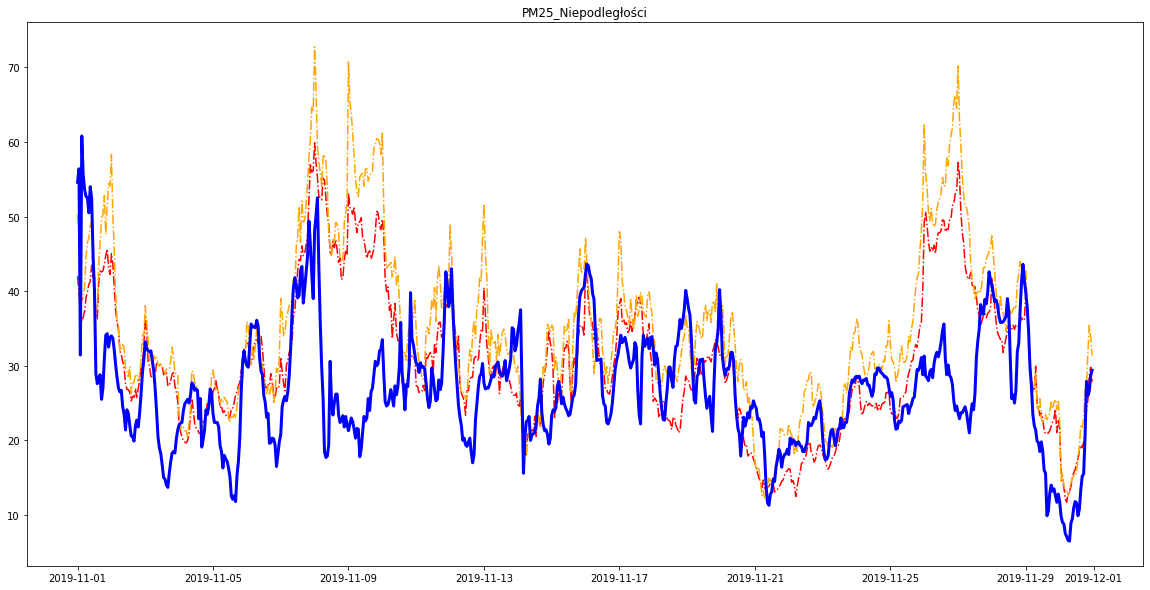

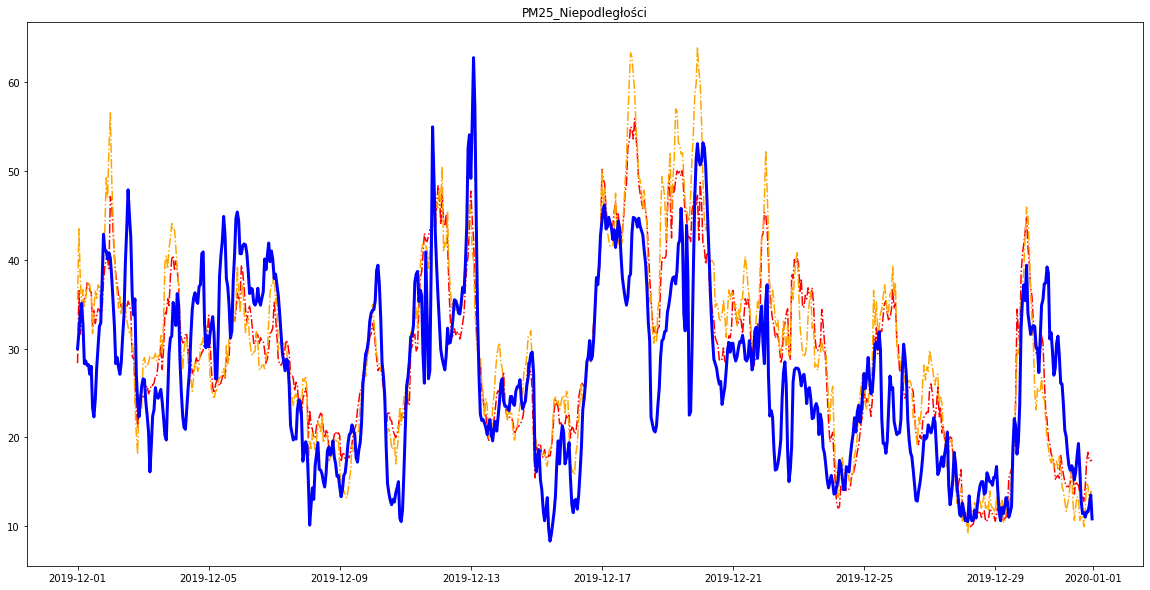

In [58]:
for mth in months:
    test_mask = df_test['month'] == mth
    plt.figure(figsize=(20,10))
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_xgb'], color='red', linestyle='dashdot') #forcast
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_lgbm'], color='orange', linestyle='dashdot') #forcast
    plt.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie'], color='blue', linewidth = 3) #actual

    plt.title('PM25_Niepodległości')
    plt.show()